### Initialization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from src.utils.simulator import batch_simulator
from scipy.stats import gaussian_kde
import torch
from os import cpu_count
from sbi.analysis import pairplot
from sbi import utils as utils
import divergences
from helper_functions import sample_from_posterior, build_theta_for_batch_simulator_from_samples_tensor

In [2]:
# Parameters

f_ref = 50
number_of_samples = 20000
time_span = 60
dt = 0.01
n_workers = cpu_count() # Number of parallel workers for the batch simulator

##### Synthetic Evaluation

In [3]:
# read in the prior

in_s = open("out/prior_NPE_synthetic1_60s_dt0.01.pickle", "rb")
try:
    prior = pickle.load(in_s)
finally:
    in_s.close()

In [4]:
# sample from the prior and generate simulation

samples_prior = prior.sample((number_of_samples,))
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_prior)
simulation_results_prior = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]

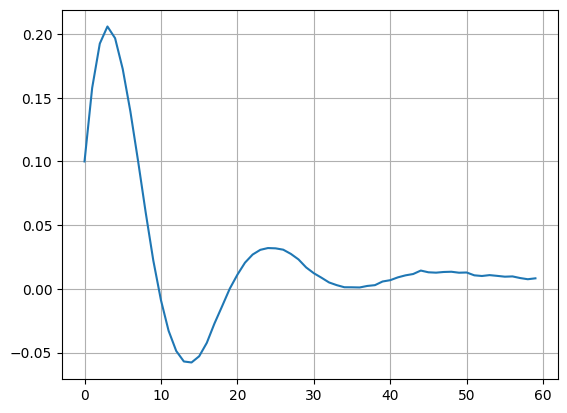

In [5]:
## we choose some specific parameters and simulate an observation for them

# format: omega_0, phi_0, c_1, c_2, P_const, P_1, epsilon
theta_true = torch.tensor([[0.1, 0.1, 0.2, 0.1, 0.1, 0.001, 0.001]]) # alternative: theta_true = prior.sample((1,))
x_obs = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1/dt)]

# plot the ground truth
plt.plot(x_obs)
plt.grid()
plt.show()

In [6]:
# reading in the NPE posterior

in_s = open("out/posterior_NPE_synthetic1_60s_dt0.01.pickle", "rb")
try:
    posterior_NPE = pickle.load(in_s)
finally:
    in_s.close()

# reading in the NRE posterior

in_s = open("out/posterior_NRE_synthetic1_60s_dt0.01.pickle", "rb")
try:
    posterior_NRE = pickle.load(in_s)
finally:
    in_s.close()

In [7]:
# sample from both posteriors
samples_NPE = sample_from_posterior(posterior_NPE, number_of_samples, x_obs)
samples_NRE = sample_from_posterior(posterior_NRE, number_of_samples, x_obs)

In [8]:
# generate simulations for samples from both posteriors

theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE)
simulation_results_posterior_NPE = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]

theta_NRE = build_theta_for_batch_simulator_from_samples_tensor(samples_NRE)
simulation_results_posterior_NRE = batch_simulator(theta_NRE, time_span, dt, n_workers)[1][:, ::int(1/dt)]

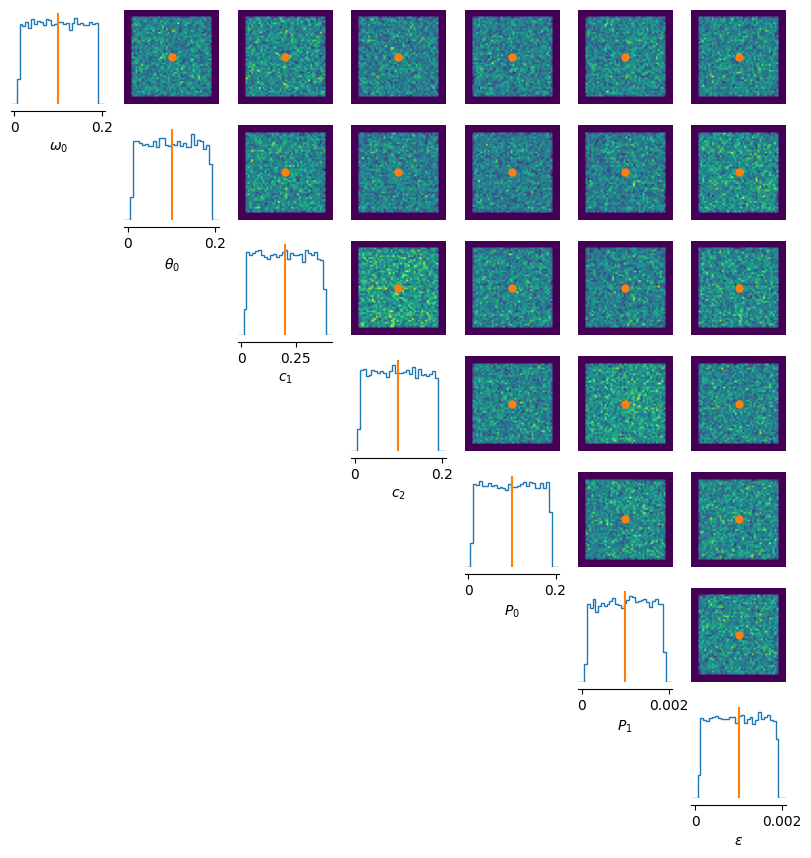

In [11]:
# plot the marginal distributions of the prior

fig, ax = pairplot(samples_prior,
             points = theta_true,
             labels=[r"$\omega_0$", r"$\theta_0$", r"$c_1$", r"$c_2$", r"$P_0$", r"$P_1$", r"$\epsilon$"])

plt.savefig("figures/synthetic_evaluation_pairplot_prior.pdf", bbox_inches="tight", format="pdf")
plt.show()

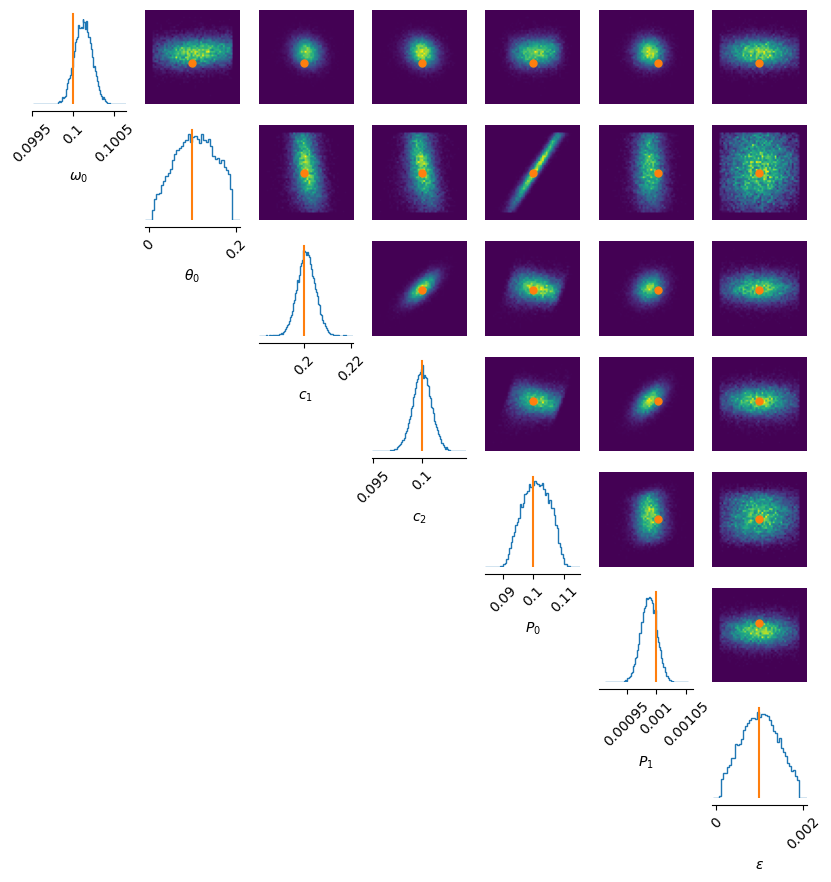

In [13]:
# plot the marginal distributions of the NPE posterior

fig, ax = pairplot(samples_NPE,
             points = theta_true,
             labels=[r"$\omega_0$", r"$\theta_0$", r"$c_1$", r"$c_2$", r"$P_0$", r"$P_1$", r"$\epsilon$"])

fig.axes[0].set_xticks([0.0995, 0.1, 0.1005])

# rotate the x-axis labels
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.savefig("figures/synthetic_evaluation_pairplot_NPE.pdf", bbox_inches="tight", format="pdf")
plt.show()

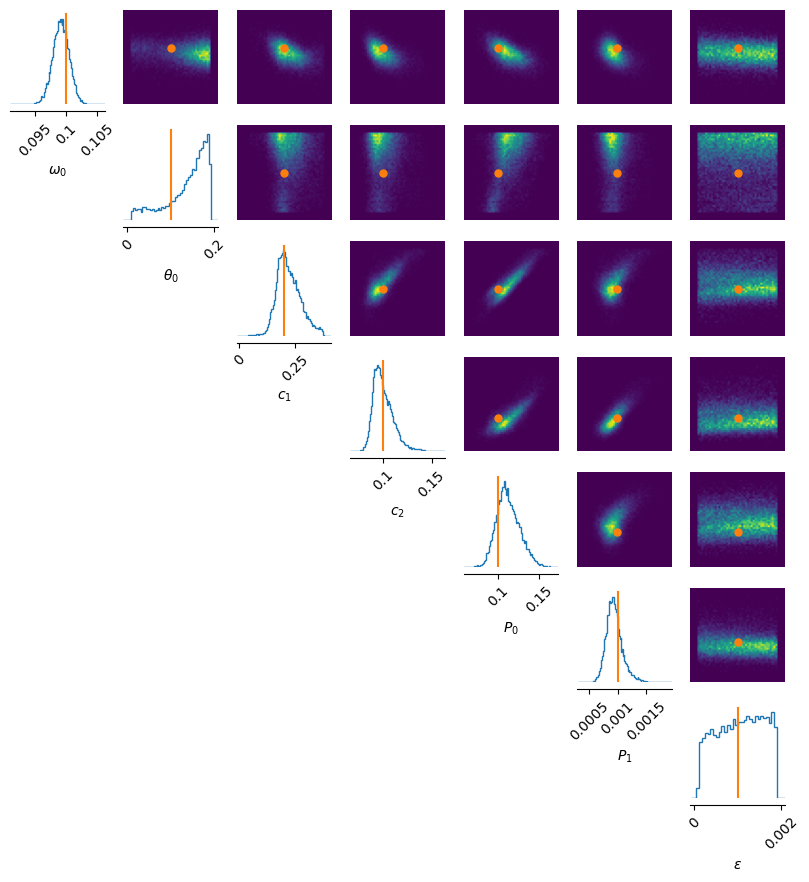

In [15]:
# plot the marginal distributions of the NRE posterior

fig, ax = pairplot(samples_NRE,
             points = theta_true,
             labels=[r"$\omega_0$", r"$\theta_0$", r"$c_1$", r"$c_2$", r"$P_0$", r"$P_1$", r"$\epsilon$"])

# rotate the x-axis labels
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)


plt.savefig("figures/synthetic_evaluation_pairplot_NRE.pdf", bbox_inches="tight", format="pdf")
plt.show()

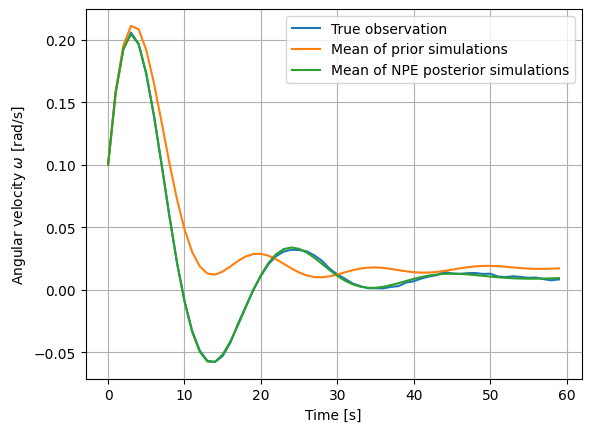

In [17]:
# plot the true observation as well as the average of the prior and NPE-posterior simulations

plt.plot(x_obs)
plt.plot(np.average(simulation_results_prior, axis=0))
plt.plot(np.average(simulation_results_posterior_NPE, axis=0))

# plot settings, including legend
plt.legend(["True observation", "Mean of prior simulations", "Mean of NPE posterior simulations"])
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity $\omega$ [rad/s]")
plt.grid()
plt.savefig("figures/synthetic_evaluation_trajectories_prior_posterior.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [18]:
# compute an estimate of the mean Jensen-Shannon divergence between the true observation and the prior simulations
# takes only 20.000 / 50 = 400 simulations to speed up computation
kde_obs = gaussian_kde(x_obs)
np.nanmean([divergences.jensen_shannon_div(kde_obs, gaussian_kde(simulation)) for simulation in simulation_results_prior[::50]])

0.12104673852819936

In [19]:
# compute an estimate of the mean Jensen-Shannon divergence between the true observation and the NPE-posterior simulations
# takes only 20.000 / 50 = 400 simulations to speed up computation
kde_obs = gaussian_kde(x_obs)
np.nanmean([divergences.jensen_shannon_div(kde_obs, gaussian_kde(simulation)) for simulation in simulation_results_posterior_NPE[::50]])

8.539915685126955e-05

In [20]:
# compute an estimate of the mean Jensen-Shannon divergence between the true observation and the NRE-posterior simulations
# takes only 20.000 / 50 = 400 simulations to speed up computation
kde_obs = gaussian_kde(x_obs)
np.nanmean([divergences.jensen_shannon_div(kde_obs, gaussian_kde(simulation)) for simulation in simulation_results_posterior_NRE[::50]])

0.005039860129081006

### Look at narrow Prior

In [21]:
# read in the prior with more narrow parameter ranges

in_s = open("out/prior_NPE_synthetic2_60s_dt0.01.pickle", "rb")
try:
    prior_narrow = pickle.load(in_s)
finally:
    in_s.close()

In [22]:
# sample from the prior and generate simulations

samples_prior_narrow = prior_narrow.sample((number_of_samples,))
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_prior_narrow)
simulation_results_prior_narrow = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]

In [23]:
# reading in the corresponding posterior

in_s = open("out/posterior_NPE_synthetic2_60s_dt0.01.pickle", "rb")
try:
    posterior_NPE_narrow = pickle.load(in_s)
finally:
    in_s.close()

In [24]:
# sample from the corresponding posterior and generate simulations
samples_NPE_narrow = sample_from_posterior(posterior_NPE_narrow, number_of_samples, x_obs)
theta = build_theta_for_batch_simulator_from_samples_tensor(samples_NPE_narrow)
simulation_results_posterior_NPE_narrow = batch_simulator(theta, time_span, dt, n_workers)[1][:, ::int(1/dt)]

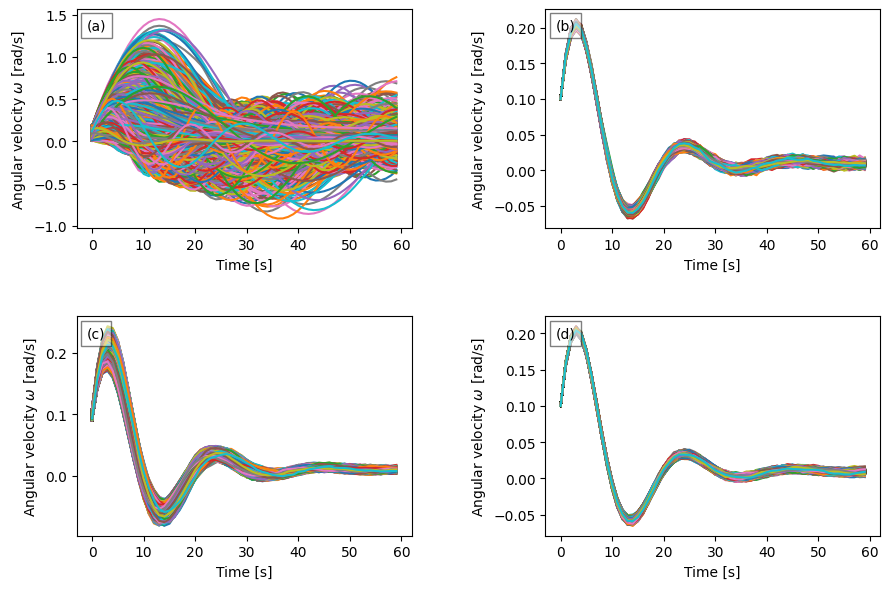

In [26]:
# generate a plot comparing the wider and narrower prior and their respective posteriors for the given observation
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# plot the simulation results of all (wide) prior samples
[axs[0][0].plot(simulation) for simulation in simulation_results_prior]
axs[0][0].set_xlabel("Time [s]")
axs[0][0].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[0][0].text(0.03, 0.955, "(a)", transform=axs[0][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# plot the simulation results of all posterior samples (with the wide prior)
[axs[0][1].plot(simulation) for simulation in simulation_results_posterior_NPE]
axs[0][1].set_xlabel("Time [s]")
axs[0][1].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[0][1].text(0.03, 0.955, "(b)", transform=axs[0][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))

    
# plot the simulation results of all narrow prior samples
[axs[1][0].plot(simulation) for simulation in simulation_results_prior_narrow]
axs[1][0].set_xlabel("Time [s]")
axs[1][0].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[1][0].text(0.03, 0.955, "(c)", transform=axs[1][0].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


# plot the simulation results of posterior samples (with the narrow prior)
[axs[1][1].plot(simulation) for simulation in simulation_results_posterior_NPE_narrow]
axs[1][1].set_xlabel("Time [s]")
axs[1][1].set_ylabel("Angular velocity $\omega$ [rad/s]")
axs[1][1].text(0.03, 0.955, "(d)", transform=axs[1][1].transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))


plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)
#plt.savefig("figures/synthetic_evaluation_narrow_vs_wide.pdf", bbox_inches="tight", format="pdf")
plt.savefig("figures/synthetic_evaluation_narrow_vs_wide.png", bbox_inches="tight", format="png", dpi=300)
plt.show()

In [ ]:
# compute an estimate of the mean Jensen-Shannon divergence between the true observation and the NPE-posterior (narrow) simulations
np.nanmean([divergences.jensen_shannon_div(gaussian_kde(x_obs), gaussian_kde(sim_narrow)) for sim_narrow in simulation_results_posterior_NPE_narrow[::100]])

5.786037437478621e-05

#### EXTRA: Studying the influence of the SDE's parameters

In [ ]:
time_span = 900
# theta format: omega_0, phi_0, c_1, c_2, P_const, P_1, epsilon

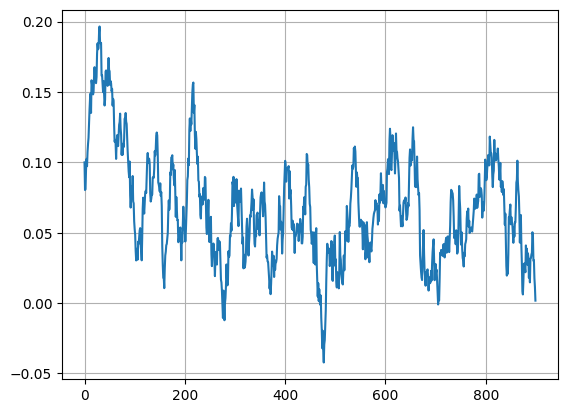

In [37]:
# all parameters are set
theta_true = torch.tensor([[0.1, 0, 0.065, 0.0005, 0.01, 0.000025, 0.01]])
plt.plot(batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1/dt)])
plt.grid()
plt.show()

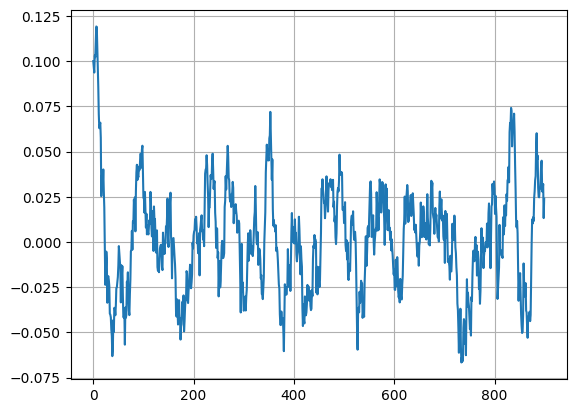

In [38]:
# same parameters, but with P_0 = P_1 = 0
theta_true = torch.tensor([[0.1, 0, 0.065, 0.0005, 0, 0, 0.01]])
plt.plot(batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1/dt)])
plt.grid()
plt.show()

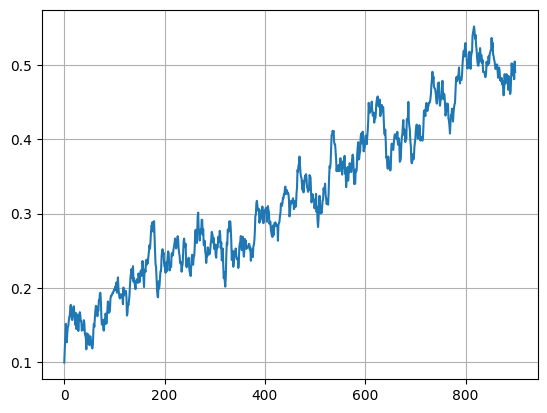

In [ ]:
# same parameters, but with c_2 = 0 (so without secondary control)
theta_true = torch.tensor([[0.1, 0, 0.065, 0, 0.01, 0.000025, 0.01]])
plt.plot(batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1/dt)])
plt.grid()
plt.show()

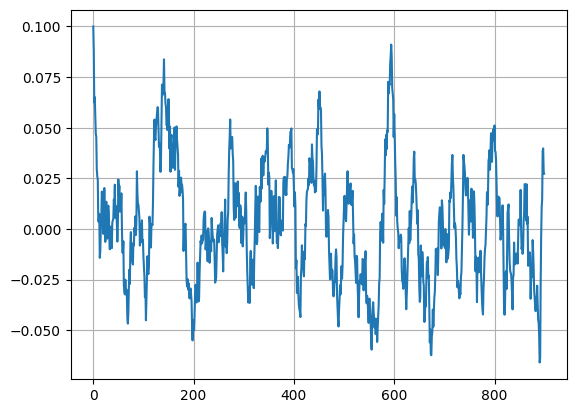

In [ ]:
# same parameters, but with c_2 = P_0 = P_1 = 0 (so without secondary control)
theta_true = torch.tensor([[0.1, 0, 0.065, 0, 0, 0, 0.01]])
plt.plot(batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1/dt)])
plt.grid()
plt.show()

##### EXTRA: Parameter sweeps

In [ ]:
# Below, we study the influence of the SDE's parameters using parameter sweeps

In [22]:
time_span = 300

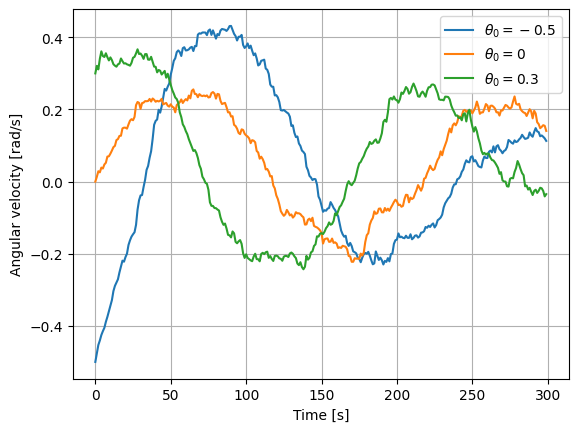

In [23]:
# parameter sweep over theta_0
theta_values = [-0.5, 0, 0.3]

for theta_0 in theta_values:
    theta_true = torch.tensor([[theta_0, 0, 0.01, 0.001, 0.01, 0.000025, 0.01]])
    sim = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1 / dt)]
    plt.plot(sim, label=f"$\\theta_0={theta_0}$")

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()

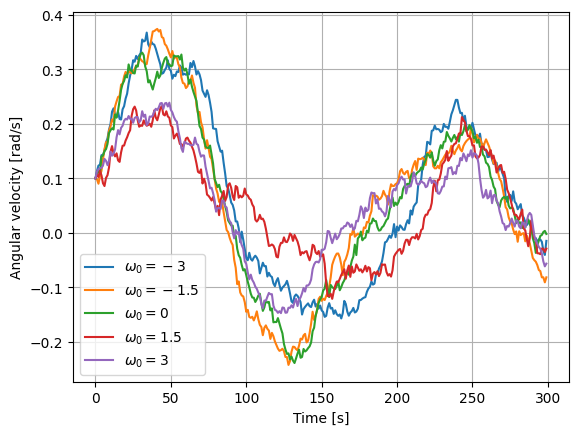

In [ ]:
# parameter sweep over omega_0
theta_values = [-3, -1.5, 0, 1.5, 3]

for omega_0 in theta_values:
    theta_true = torch.tensor([[0.1, omega_0, 0.01, 0.001, 0.01, 0.000025, 0.01]])
    sim = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1 / dt)]
    plt.plot(sim, label=f"$\omega_0={omega_0}$")

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()

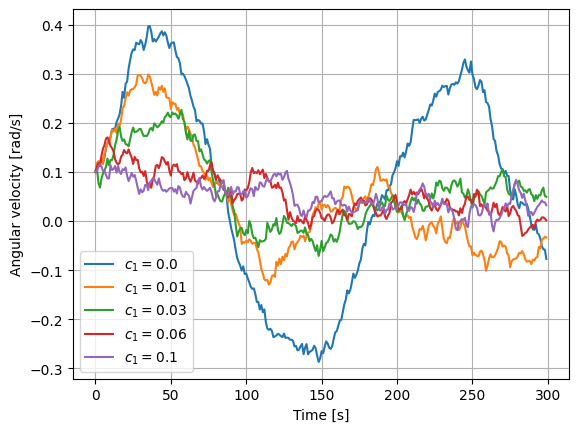

In [24]:
# parameter sweep over primary control c_1
theta_values = [0.0, 0.01, 0.03, 0.06, 0.1]

for c_1 in theta_values:
    theta_true = torch.tensor([[0.1, 0, c_1, 0.001, 0.01, 0.000025, 0.01]])
    sim = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1 / dt)]
    plt.plot(sim, label=f"$c_1={c_1}$")

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()

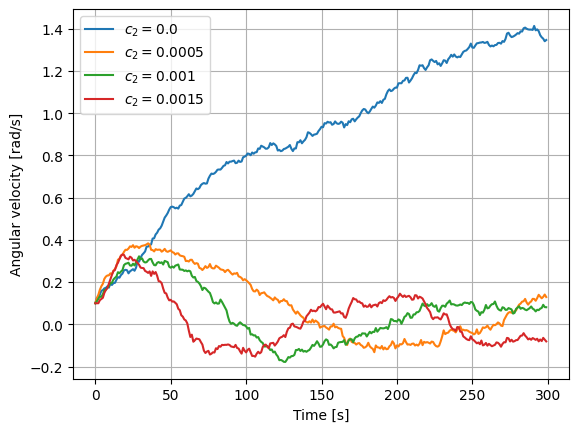

In [32]:
# parameter sweep over secondary control c_2
theta_values = [0.0, 0.0005, 0.001, 0.0015]

for c_2 in theta_values:
    theta_true = torch.tensor([[0.1, 0, 0.01, c_2, 0.01, 0.000025, 0.01]])
    sim = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1 / dt)]
    plt.plot(sim, label=f"$c_2={c_2}$")

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()

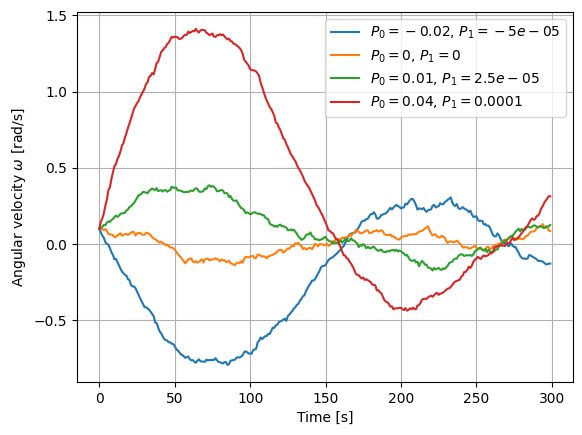

In [28]:
# parameter sweep over power mismatch P_0 and P_1
theta_values = [(-0.02, -0.00005), (0, 0), (0.01, 0.000025), (0.04, 0.0001)]

for P_0, P_1 in theta_values:
    theta_true = torch.tensor([[0.1, 0, 0.01, 0.0005, P_0, P_1, 0.01]])
    sim = batch_simulator(build_theta_for_batch_simulator_from_samples_tensor(theta_true), time_span, dt, n_workers)[1][0][::int(1 / dt)]
    plt.plot(sim, label=f"$P_0={P_0}$, $P_1={P_1}$")

plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Angular velocity $\omega$ [rad/s]")
plt.show()